<a href="https://colab.research.google.com/github/aakhterov/ML_algorithms_from_scratch/blob/master/A_B_testing_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0 - Getting Started

"Graffit" is a mobile app for listening to and watching various audio and video sources, making bookmarks, and transcribing audio fragments into text.

A graffit's team uses social media advertising to attract potential customers to their site. A product manager thinks the current ad banner can be improved and increase CTR. A new banner is ready but the product manager wants to conduct an A/B test before launch.

**Note**: This notebook based on the AB Testing Course on https://www.datainterview.com

In [24]:
from datetime import datetime
import math
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MultipleLocator
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportions_chisquare, confint_proportions_2indep
from scipy.stats import norm

from google.colab import drive
drive.mount('/content/drive/')

SEED = 123
np.random.seed(SEED)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/a_b_test_ctr.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%y')
df.head()

,Date,Impressions,Clicks,is_new_banner
0,2023-09-01,1093,12,0
1,2023-09-02,1132,2,0
2,2023-09-03,1076,10,0
3,2023-09-04,1103,11,0
4,2023-09-05,1064,8,0


In [3]:
df['CTR'] = df['Clicks']*100/df['Impressions']

In [4]:
current_ctr_mean = df['CTR'].mean().round(2)
current_ctr_mean

0.85

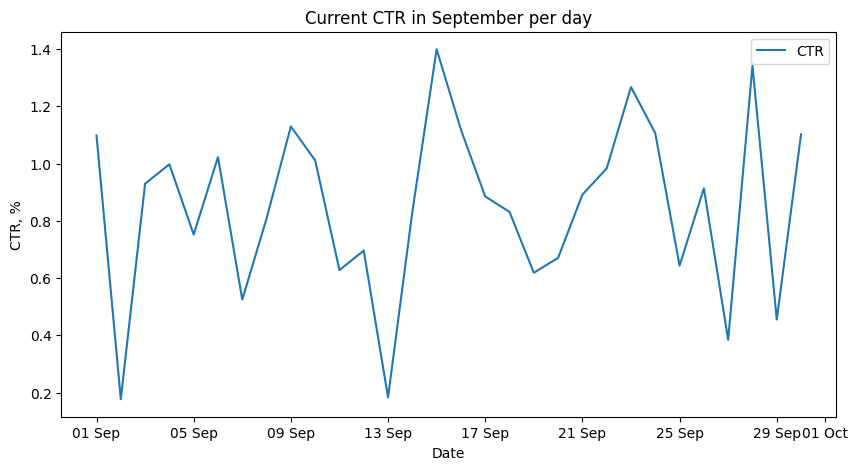

In [5]:
_, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=df['Date'], y=df['CTR'])
plt.legend(labels=["CTR"])
plt.ylabel('CTR, %')
ax.xaxis.set_major_formatter(DateFormatter("%d %b"))
plt.title('Current CTR in September per day')
plt.show()

# Step 2 - State the Hypothesis

The second step of the experiment is to state the hypothesis. This is followed by setting parameter values such as the significance level (alpha), statistical power and minimum detctable effect (MDE).

$ H_0 $: The CTRs for the new banner and for the old one are the same.

$ H_a $ : The CTRs for the new banner and for the old one are different.

In [6]:
alpha = 0.05 # the segnificane level
power = 0.80 # the statistical power
mde = 0.10 # the minimum detectable effect (MDE)

p1 = current_ctr_mean
p2 = current_ctr_mean * (1 + mde)

print(p1, p2)

0.85 0.935


# Step 3 - Design the Experiment

The third step of the experiment is the design the experiment which involves determining the randomization unit, calculating the sample size and determining the experiment duration. We will explore how to calculate the sample size and experiment duration in this section.

## Calculate Sample Size

In [7]:
effect_size = sm.stats.proportion_effectsize(p2, p1)
effect_size

0.27980482393805284

In [18]:
nobs1 = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power)
n = math.ceil(nobs1)
N = 2*n

In [28]:
norm.ppf(1-alpha/2), norm.ppf(power)

(1.959963984540054, 0.8416212335729143)

In [35]:
((norm.ppf(1-alpha/2) + norm.ppf(power))**2)*2*df['CTR'].std()**2/(p2-p1)**2

206.51666105931025

In [37]:
2*(norm.ppf(1-alpha/2) + norm.ppf(power))**2

15.697759468698177